# Generational changes in religious attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [64]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)

from statsmodels.discrete.discrete_model import MNLogit

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

In [65]:
# !wget https://gssdataexplorer.norc.org/extracts/21438/download

In [66]:
gss = utils.ReadGss('gss_religion_data')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Cleaning variables

In [67]:
# TODO: find out what code 4 is

gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)

In [68]:
utils.values(gss, 'bible')

1.0    11185
2.0    15926
3.0     5929
Name: bible, dtype: int64

In [69]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)

In [70]:
utils.values(gss, 'conclerg')

1.0    11366
2.0    20886
3.0     8660
Name: conclerg, dtype: int64

In [71]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40129

In [72]:
utils.values(gss, 'god')

1.0      673
2.0     1110
3.0     2286
4.0      900
5.0     3662
6.0    13706
Name: god, dtype: int64

In [73]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

In [74]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

In [75]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [76]:
gss.dropna(subset=['age', 'cohort', 'relig'], inplace=True)
gss.shape

(61995, 11)

We drop 471 records due to missing data.

In [77]:
62466 - 61995

471

Here's the distribution of ages.

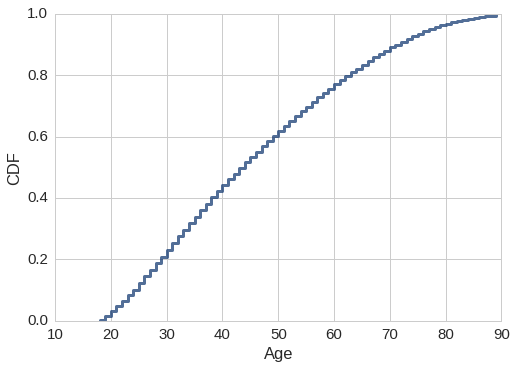

In [78]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [79]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

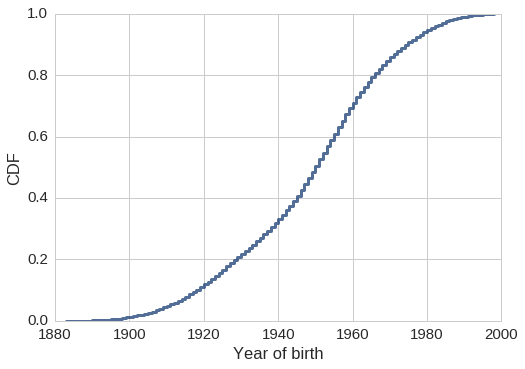

In [80]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [81]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=4) + 2.5

In [82]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.relig.count()
counts

cohort5
1881.5       2
1886.5      37
1891.5     140
1896.5     365
1901.5     726
1906.5    1113
1911.5    1648
1916.5    2281
1921.5    2798
1926.5    3131
1931.5    3074
1936.5    3632
1941.5    4343
1946.5    5616
1951.5    6349
1956.5    6465
1961.5    5556
1966.5    4413
1971.5    3483
1976.5    2631
1981.5    2044
1986.5    1280
1991.5     658
1996.5     210
Name: relig, dtype: int64

In [83]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

Here's the distribution of religion codes.

In [84]:
utils.values(gss, 'relig')

1.0     35856
2.0     15136
3.0      1233
4.0      7231
5.0      1064
6.0       177
7.0        88
8.0        38
9.0       135
10.0      112
11.0      760
12.0       30
13.0      135
Name: relig, dtype: int64

In [85]:
utils.values(gss, 'year')

1972    1603
1973    1496
1974    1477
1975    1483
1976    1491
1977    1516
1978    1522
1980    1456
1982    1837
1983    1588
1984    1456
1985    1522
1986    1460
1987    1802
1988    1476
1989    1530
1990    1367
1991    1513
1993    1592
1994    2976
1996    2894
1998    2792
2000    2805
2002    2735
2004    2792
2006    4468
2008    2004
2010    2028
2012    1962
2014    2513
2016    2839
Name: year, dtype: int64

In [86]:
sum(gss.relig.isnull())

0

In [87]:

def create_relig_vars(df):
    """Creates columns for religious categories.
    
    df: DataFrame
    """
    # lumping "Orthodox-Christian" and "Christian" with Protestant
    df['prot'] = (df.relig.isin([1,10,11]))
    df['cath'] = (df.relig==2)
    df['none'] = (df.relig==4)
    df['other'] = (df.relig.isin([3,5,6,7,8,9,12,13]))
    
    df['relig4'] = df.relig.copy()
    df.relig4.replace([10, 11], 1, inplace=True)
    df.relig4.replace([5,6,7,8,9,12,13], 3, inplace=True)

    varnames = ['prot', 'cath', 'none', 'other']
    df.loc[df.relig.isnull(), varnames + ['relig4']] = np.nan
    
create_relig_vars(gss)

In [88]:
utils.values(gss, 'relig4')

1.0    36728
2.0    15136
3.0     2900
4.0     7231
Name: relig4, dtype: int64

In [89]:
sum(gss.god.isnull())

39773

In [90]:
def create_belief_vars(df):
    """Creates columns for belief categories.
    
    df: DataFrame
    """
    df['nobelief'] = (df.god.isin([1, 2]))
    df['belief'] = (df.god.isin([3, 4, 5]))
    df['strongbelief'] = (df.god.isin([6]))
    
    df['belief3'] = df.god.copy()
    df.belief3.replace([1, 2], 1, inplace=True)
    df.belief3.replace([3, 4, 5], 2, inplace=True)
    df.belief3.replace([6], 3, inplace=True)

    varnames = ['strongbelief', 'belief', 'nobelief', 'belief3']
    df.loc[df.god.isnull(), varnames] = np.nan
    
create_belief_vars(gss)

In [91]:
utils.values(gss, 'belief3')

1.0     1778
2.0     6819
3.0    13625
Name: belief3, dtype: int64

In [92]:
sum(gss.conclerg.isnull())

21354

In [93]:
def create_conf_vars(df):
    """Creates columns for confidence in religion categories.
    
    df: DataFrame
    """
    df['confident'] = (df.conclerg == 1)
    df['someconf'] = (df.conclerg == 2)
    df['noconf'] = (df.conclerg == 3)

    varnames = ['confident', 'someconf', 'noconf']
    df.loc[df.conclerg.isnull(), varnames] = np.nan
    
create_conf_vars(gss)

In [94]:
utils.values(gss, 'conclerg')

1.0    11308
2.0    20740
3.0     8593
Name: conclerg, dtype: int64

In [95]:
sum(gss.bible.isnull())

29138

In [96]:
def create_bible_vars(df):
    """Creates columns for bible interpretation categories.
    
    df: DataFrame
    """
    df['word'] = (df.bible == 1)
    df['inspired'] = (df.bible == 2)
    df['legends'] = (df.bible == 3)

    varnames = ['word', 'inspired', 'legends']
    df.loc[df.bible.isnull(), varnames] = np.nan
    
create_bible_vars(gss)

In [97]:
utils.values(gss, 'bible')

1.0    11123
2.0    15843
3.0     5891
Name: bible, dtype: int64

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [98]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,nobelief,belief,strongbelief,belief3,confident,someconf,noconf,word,inspired,legends
0,1972,NaN,NaN,1930.0,42.0,0.8893,0,1.0,12,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1972,NaN,NaN,1920.0,52.0,1.7786,0,2.0,8,819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1972,NaN,NaN,1929.0,43.0,1.3339,0,2.0,11,1053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1972,NaN,NaN,1932.0,40.0,1.3339,0,5.0,12,326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1972,NaN,NaN,1940.0,32.0,0.8893,0,2.0,12,984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['c2'] = df.c**2
    df['a'] = df.age - 47
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [100]:
center_factors(sample)

In [101]:
formula = 'prot ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.665717
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Tue, 30 May 2017   Pseudo R-squ.:                 0.01974
Time:                        16:55:04   Log-Likelihood:                -41271.
converged:                       True   LL-Null:                       -42102.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0716      0.016      4.343      0.000       0.039       0.104
c             -0.0196      0.001    -22.175      0.000      -0.021      -0.018
c2         -8.728e-05   1.85e-05     -4.719      0.000      -0.000    -5.1e-05
a             -0.0002      0.001     -0.286      0.775      -0.002       0.001
a2          3.228e-05   3.16e-05      1.023      0.306   -2.96e-05    9.41e-05
==============================================================================
"""

In [102]:
formula = 'cath ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.566227
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Tue, 30 May 2017   Pseudo R-squ.:                0.001493
Time:                        16:55:04   Log-Likelihood:                -35103.
converged:                       True   LL-Null:                       -35156.
                                        LLR p-value:                 8.548e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1216      0.019    -59.776      0.000      -1.158      -1.085
c             -0.0054      0.001     -5.421      0.000      -0.007      -0.003
c2         -9.223e-05   2.06e-05     -4.473      0.000      -0.000   -5.18e-05
a             -0.0062      0.001     -7.047      0.000      -0.008      -0.004
a2          1.581e-05   3.51e-05      0.450      0.652    -5.3e-05    8.46e-05
==============================================================================
"""

In [103]:
formula = 'none ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.334222
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Tue, 30 May 2017   Pseudo R-squ.:                 0.06301
Time:                        16:55:04   Log-Likelihood:                -20720.
converged:                       True   LL-Null:                       -22113.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5150      0.024    -63.654      0.000      -1.562      -1.468
c              0.0409      0.001     33.595      0.000       0.039       0.043
c2          -5.89e-05   3.36e-05     -1.751      0.080      -0.000    7.05e-06
a              0.0127      0.001      9.608      0.000       0.010       0.015
a2             0.0001   5.54e-05      2.013      0.044    2.92e-06       0.000
==============================================================================
"""

In [104]:
formula = 'other ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.189399
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Tue, 30 May 2017   Pseudo R-squ.:                0.003594
Time:                        16:55:04   Log-Likelihood:                -11742.
converged:                       True   LL-Null:                       -11784.
                                        LLR p-value:                 1.745e-17
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8059      0.037    -76.498      0.000      -2.878      -2.734
c              0.0119      0.002      6.147      0.000       0.008       0.016
c2          4.793e-05   4.24e-05      1.130      0.258   -3.52e-05       0.000
a              0.0035      0.002      1.924      0.054   -6.59e-05       0.007
a2            -0.0001   7.52e-05     -1.847      0.065      -0.000    8.47e-06
==============================================================================
"""

## Generational replacement

Choose colors

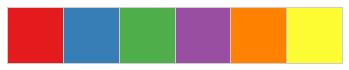

In [105]:
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')
sns.palplot(sns.color_palette('Set1'))

In [106]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        thinkplot.plot(series, color=color, label=label)

In [107]:
def plot_relig(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    varnames = ['prot', 'cath', 'none', 'other']
    colors = [ORANGE, GREEN, RED, BLUE]
    labels = ['Protestant', 'Catholic', 'None', 'Other']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [108]:
grouped_year = sample.groupby(['year'])
grouped_year.none.count()

year
1972    1603
1973    1496
1974    1477
1975    1483
1976    1491
1977    1516
1978    1522
1980    1456
1982    1837
1983    1588
1984    1456
1985    1522
1986    1460
1987    1802
1988    1476
1989    1530
1990    1367
1991    1513
1993    1592
1994    2976
1996    2894
1998    2792
2000    2805
2002    2735
2004    2792
2006    4468
2008    2004
2010    2028
2012    1962
2014    2513
2016    2839
Name: none, dtype: int64

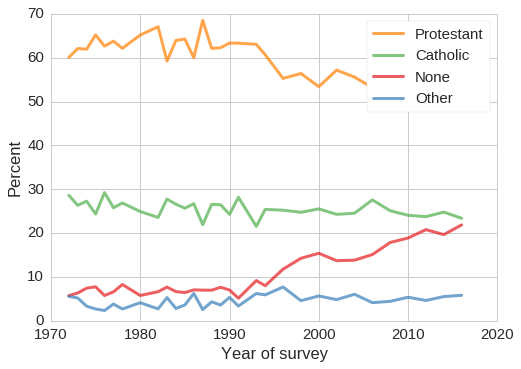

In [109]:
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent')

In [110]:
grouped_age = sample.groupby(['age_group'])
grouped_age.none.count()

age_group
17.5    1499
22.5    6316
27.5    6576
32.5    6359
37.5    6176
42.5    6121
47.5    5889
52.5    5222
57.5    4647
62.5    3939
67.5    3184
72.5    2584
77.5    1767
82.5    1074
87.5     642
Name: none, dtype: int64

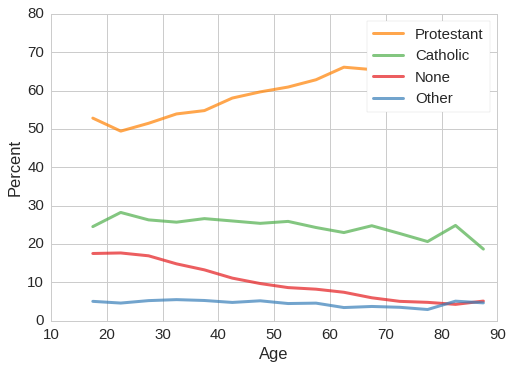

In [111]:
plot_relig(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

In [112]:
grouped_cohort = sample.groupby(['cohort5'])
counts = grouped_cohort.relig.count()
counts

cohort5
1881.5       1
1886.5      33
1891.5      90
1896.5     250
1901.5     613
1906.5     910
1911.5    1431
1916.5    1991
1921.5    2636
1926.5    3027
1931.5    3037
1936.5    3665
1941.5    4325
1946.5    5653
1951.5    6402
1956.5    6512
1961.5    5654
1966.5    4604
1971.5    3636
1976.5    2717
1981.5    2348
1986.5    1360
1991.5     774
1996.5     326
Name: relig, dtype: int64

In [113]:
since_1900 = sample.loc[sample.cohort >= 1900]
grouped_cohort = since_1900.groupby(['cohort5'])

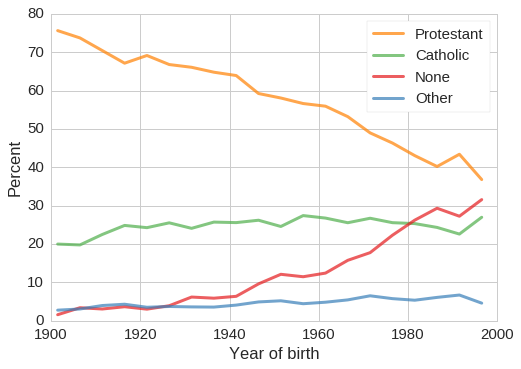

In [114]:
plot_relig(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

Before running models, center the factors we're planning to use.

In [115]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['c2'] = df.c**2
    df['a'] = df.age - 47
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [116]:
center_factors(sample)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,noconf,word,inspired,legends,ones,c,c2,a,a2,ac
0,1972,NaN,NaN,1930.0,42.0,0.8893,0,1.0,12,27,...,NaN,NaN,NaN,NaN,1.0,-36.0,1296.0,-5.0,25.0,180.0
1,1972,NaN,NaN,1920.0,52.0,1.7786,0,2.0,8,819,...,NaN,NaN,NaN,NaN,1.0,-46.0,2116.0,5.0,25.0,-230.0
2,1972,NaN,NaN,1929.0,43.0,1.3339,0,2.0,11,1053,...,NaN,NaN,NaN,NaN,1.0,-37.0,1369.0,-4.0,16.0,148.0
3,1972,NaN,NaN,1932.0,40.0,1.3339,0,5.0,12,326,...,NaN,NaN,NaN,NaN,1.0,-34.0,1156.0,-7.0,49.0,238.0
4,1972,NaN,NaN,1940.0,32.0,0.8893,0,2.0,12,984,...,NaN,NaN,NaN,NaN,1.0,-26.0,676.0,-15.0,225.0,390.0


## Religious affiliation

Run logistic regression to fit models to each religious group.

In [117]:
def make_model(df, var):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    """
    formula = var + ' ~ c + c2 + a + a2 + ac'
    return smf.logit(formula, data=df).fit()

In [118]:
make_model(sample, 'prot').summary()

Optimization terminated successfully.
         Current function value: 0.665295
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                 0.02036
Time:                        16:55:06   Log-Likelihood:                -41245.
converged:                       True   LL-Null:                       -42102.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0017      0.019     -0.090      0.928      -0.040       0.036
c             -0.0335      0.002    -15.861      0.000      -0.038      -0.029
c2            -0.0004   5.31e-05     -8.425      0.000      -0.001      -0.000
a             -0.0153      0.002     -6.879      0.000      -0.020      -0.011
a2            -0.0004   6.65e-05     -5.897      0.000      -0.001      -0.000
ac            -0.0008      0.000     -7.238      0.000      -0.001      -0.001
==============================================================================
"""

In [119]:
make_model(sample, 'cath').summary()

Optimization terminated successfully.
         Current function value: 0.566180
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                0.001577
Time:                        16:55:07   Log-Likelihood:                -35100.
converged:                       True   LL-Null:                       -35156.
                                        LLR p-value:                 2.686e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0931      0.022    -49.526      0.000      -1.136      -1.050
c             -0.0002      0.002     -0.066      0.947      -0.005       0.004
c2          4.269e-05   5.92e-05      0.721      0.471   -7.34e-05       0.000
a             -0.0004      0.003     -0.175      0.861      -0.005       0.004
a2             0.0002   7.42e-05      2.356      0.018    2.94e-05       0.000
ac             0.0003      0.000      2.430      0.015    5.74e-05       0.001
==============================================================================
"""

In [120]:
make_model(sample, 'none').summary()

Optimization terminated successfully.
         Current function value: 0.333788
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                 0.06423
Time:                        16:55:07   Log-Likelihood:                -20693.
converged:                       True   LL-Null:                       -22113.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4240      0.027    -53.727      0.000      -1.476      -1.372
c              0.0617      0.003     20.099      0.000       0.056       0.068
c2             0.0005   8.49e-05      6.113      0.000       0.000       0.001
a              0.0350      0.003     10.674      0.000       0.029       0.041
a2             0.0008      0.000      7.441      0.000       0.001       0.001
ac             0.0013      0.000      7.407      0.000       0.001       0.002
==============================================================================
"""

In [121]:
make_model(sample, 'other').summary()

Optimization terminated successfully.
         Current function value: 0.189343
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                0.003887
Time:                        16:55:07   Log-Likelihood:                -11738.
converged:                       True   LL-Null:                       -11784.
                                        LLR p-value:                 3.082e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8640      0.043    -65.967      0.000      -2.949      -2.779
c              0.0005      0.005      0.110      0.913      -0.009       0.010
c2            -0.0003      0.000     -2.062      0.039      -0.000   -1.26e-05
a             -0.0090      0.005     -1.748      0.081      -0.019       0.001
a2            -0.0005      0.000     -3.154      0.002      -0.001      -0.000
ac            -0.0007      0.000     -2.608      0.009      -0.001      -0.000
==============================================================================
"""

In [122]:
formula = 'relig4 ~ a + c'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.028609
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 relig4   No. Observations:                61995
Model:                        MNLogit   Df Residuals:                    61986
Method:                           MLE   Df Model:                            6
Date:                Tue, 30 May 2017   Pseudo R-squ.:                 0.02522
Time:                        16:55:08   Log-Likelihood:                -63769.
converged:                       True   LL-Null:                       -65419.
                                        LLR p-value:                     0.000
==============================================================================
  relig4=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7423      0.017    -42.722      0.000      -0.776      -0.708
a             -0.0044      0.001     -4.943      0.000      -0.006      -0.003
c              0.0055      0.001      7.329      0.000       0.004       0.007
------------------------------------------------------------------------------
  relig4=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2194      0.033    -67.665      0.000      -2.284      -2.155
a              0.0042      0.002      2.310      0.021       0.001       0.008
c              0.0175      0.002     11.560      0.000       0.015       0.020
------------------------------------------------------------------------------
  relig4=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0404      0.021    -48.823      0.000      -1.082      -0.999
a              0.0109      0.001      8.288      0.000       0.008       0.013
c              0.0446      0.001     40.626      0.000       0.042       0.047
==============================================================================
"""

## Multinomial models

In [123]:
def make_multi_model(df, var, factors):
    """Fit a multinomial logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factors
    
    returns: MNLogit model
    """
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return MNLogit(y, X, missing='drop').fit()

In [124]:
def predict_multi_model(age, model, year, factors, index):
    """Make a prediction based on a fitted model.
    
    age: Series of ages to simulate
    model: MNLogit model
    year: year to make a prediction for
    factors: list of string names for factors
    index: list of strings, index of result Series
    
    returns: Series that maps variable name to percentage
    """
    # TODO: consider resampling age and using
    # binomial rather than mean
    # age = thinkstats2.Resample(sample.age)
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    X = df[factors].values
    pred = model.predict(X).mean(axis=0)
    return pd.Series(pred, index=index) * 100

In [125]:
train_year = 2016
train = sample[sample.year <= train_year]

In [126]:
factors = ['ones', 'a', 'c']
model = make_multi_model(train, 'relig4', factors)

Optimization terminated successfully.
         Current function value: 1.028609
         Iterations 6


In [127]:
age = sample.loc[sample.year==train_year, 'age']
index = ['prot', 'cath', 'other', 'none']

In [128]:
predict_multi_model(age, model, 1976, factors, index)

prot     65.854726
cath     25.463243
other     3.742342
none      4.939689
dtype: float64

In [129]:
predict_multi_model(age, model, 2016, factors, index)

prot     49.779107
cath     23.586123
other     5.580839
none     21.053930
dtype: float64

In [130]:
predict_multi_model(age, model, 2026, factors, index)

prot     43.956733
cath     21.850001
other     5.817891
none     28.375375
dtype: float64

In [131]:
predict_multi_model(age, model, 2036, factors, index)

prot     37.614105
cath     19.593557
other     5.868586
none     36.923752
dtype: float64

In [132]:
def plot_predictions(series_seq, colors):
    """Plot a sequence of series.
    
    series_seq: list of series
    """
    alpha = 0.3
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)

In [135]:
def make_multi_pred(df, var, varnames, train_year, years, factors, index):
    train = df[df.year <= train_year]
    age = df.loc[df.year==train_year, 'age']

    model = make_multi_model(train, var, factors)
    
    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year, factors, index)
    return pred

def plot_multi_pred(df, pred, varnames, colors):
    series_seq = [pred[var] for var in varnames]
    plot_predictions(series_seq, colors)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

Optimization terminated successfully.
         Current function value: 1.002518
         Iterations 6


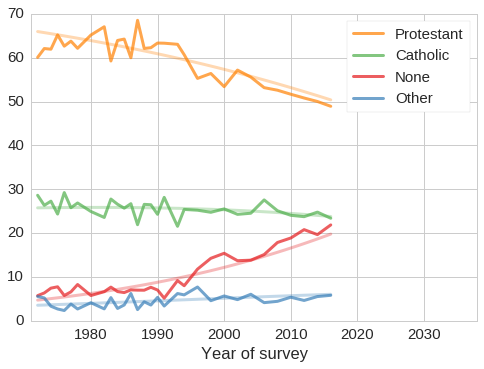

In [136]:
var = 'relig4'
varnames = ['prot', 'cath', 'none', 'other']
colors = [ORANGE, GREEN, RED, BLUE]
train_year = 2006
years = np.arange(1972, 2017)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)
thinkplot.config(xlim=[1971, 2038])

Optimization terminated successfully.
         Current function value: 1.028609
         Iterations 6


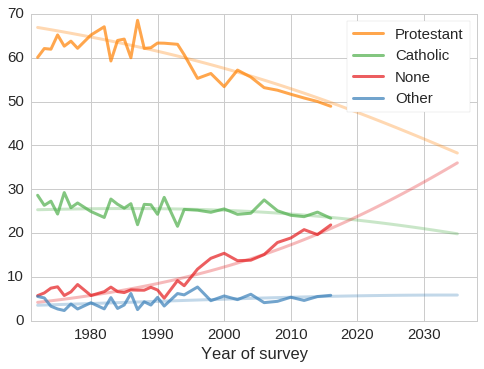

In [137]:
train_year = 2016
years = np.arange(1972, 2036)

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)

thinkplot.config(xlim=[1971, 2038])

## Belief in God

I don''t believe in God.....................1 

I don''t know whether there is a God and I don''t believe there is any way to find out..................................2

I don''t believe in a personal God, but I do believe in a Higher Power of some kind........................3 

I find myself believing in God some of the time, but not at others........4 

While I have doubts, I feel that I do believe in God….............................5 

I know God really exists and I have no doubts about it...........................6

In [138]:
RED, PINK, _, _, LTBLUE, DKBLUE = sns.color_palette('RdBu', 6)
belief_colors = [BLUE, PURPLE, RED]

In [139]:
def plot_beliefs(grouped):
    """Plot belief categories.
    
    grouped: GroupBy object
    """
    varnames = ['strongbelief', 'belief', 'nobelief']
    colors = [BLUE, PURPLE, RED]
    labels = ['Strong belief', 'Belief', 'No belief']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

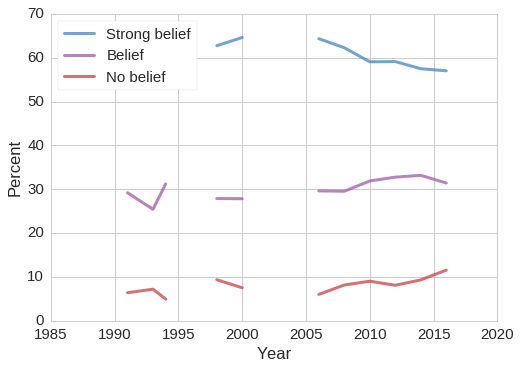

In [140]:
plot_beliefs(grouped_year)
thinkplot.config(xlabel='Year', ylabel='Percent', loc='upper left')

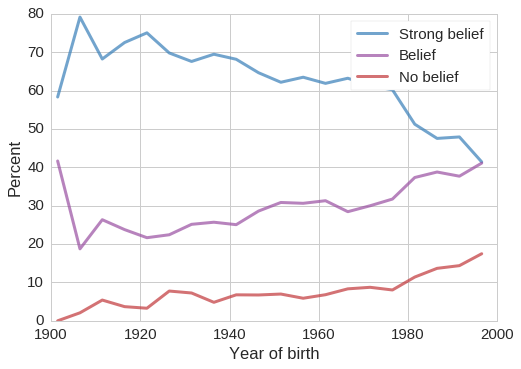

In [141]:
plot_beliefs(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [142]:
make_model(sample, 'strongbelief').summary()

Optimization terminated successfully.
         Current function value: 0.657587
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           strongbelief   No. Observations:                22162
Model:                          Logit   Df Residuals:                    22156
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                 0.01305
Time:                        16:56:29   Log-Likelihood:                -14573.
converged:                       True   LL-Null:                       -14766.
                                        LLR p-value:                 4.145e-81
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4314      0.023     18.679      0.000       0.386       0.477
c             -0.0336      0.005     -7.151      0.000      -0.043      -0.024
c2            -0.0009      0.000     -4.293      0.000      -0.001      -0.001
a             -0.0188      0.005     -3.934      0.000      -0.028      -0.009
a2            -0.0011      0.000     -4.860      0.000      -0.002      -0.001
ac            -0.0018      0.000     -4.133      0.000      -0.003      -0.001
==============================================================================
"""

In [143]:
make_model(sample, 'belief').summary()

Optimization terminated successfully.
         Current function value: 0.610778
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 belief   No. Observations:                22162
Model:                          Logit   Df Residuals:                    22156
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                0.006064
Time:                        16:56:29   Log-Likelihood:                -13536.
converged:                       True   LL-Null:                       -13619.
                                        LLR p-value:                 7.789e-34
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8013      0.024    -32.860      0.000      -0.849      -0.753
c              0.0207      0.005      4.194      0.000       0.011       0.030
c2             0.0006      0.000      2.673      0.008       0.000       0.001
a              0.0106      0.005      2.114      0.034       0.001       0.020
a2             0.0008      0.000      3.183      0.001       0.000       0.001
ac             0.0013      0.000      2.771      0.006       0.000       0.002
==============================================================================
"""

In [144]:
make_model(sample, 'nobelief').summary()

Optimization terminated successfully.
         Current function value: 0.275155
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               nobelief   No. Observations:                22162
Model:                          Logit   Df Residuals:                    22156
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                 0.01531
Time:                        16:56:30   Log-Likelihood:                -6098.0
converged:                       True   LL-Null:                       -6192.8
                                        LLR p-value:                 4.575e-39
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4146      0.041    -59.190      0.000      -2.495      -2.335
c              0.0442      0.008      5.388      0.000       0.028       0.060
c2             0.0010      0.000      2.677      0.007       0.000       0.002
a              0.0287      0.008      3.413      0.001       0.012       0.045
a2             0.0013      0.000      3.227      0.001       0.001       0.002
ac             0.0020      0.001      2.518      0.012       0.000       0.003
==============================================================================
"""

In [145]:
formula = 'belief3 ~ c + a'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.854783
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                belief3   No. Observations:                22162
Model:                        MNLogit   Df Residuals:                    22156
Method:                           MLE   Df Model:                            4
Date:                Tue, 30 May 2017   Pseudo R-squ.:                0.009864
Time:                        16:56:30   Log-Likelihood:                -18944.
converged:                       True   LL-Null:                       -19132.
                                        LLR p-value:                 2.059e-80
==============================================================================
 belief3=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2372      0.034     36.051      0.000       1.170       1.305
c             -0.0168      0.003     -5.479      0.000      -0.023      -0.011
a             -0.0104      0.003     -3.101      0.002      -0.017      -0.004
------------------------------------------------------------------------------
 belief3=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8684      0.033     57.461      0.000       1.805       1.932
c             -0.0280      0.003     -9.599      0.000      -0.034      -0.022
a             -0.0093      0.003     -2.934      0.003      -0.016      -0.003
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.854783
         Iterations 6


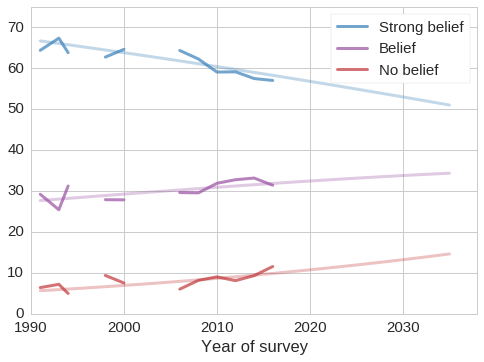

In [146]:
var = 'belief3'
varnames = ['strongbelief', 'belief', 'nobelief']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1991, 2036)
factors = ['ones', 'a', 'c']
index = ['nobelief', 'belief', 'strongbelief']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_beliefs(grouped_year)

thinkplot.config(xlim=[1990, 2038], ylim=[0, 75])

In [147]:
make_multi_pred(sample, var, varnames, train_year, [1996, 2016, 2036], factors, index)

Optimization terminated successfully.
         Current function value: 0.854783
         Iterations 6


,strongbelief,belief,nobelief
1996,65.112642,28.556929,6.330430
2016,58.273611,31.858128,9.868261
2036,50.618055,34.468603,14.913341


## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [148]:
def plot_conf(grouped):
    """Plot confidence in religion categories.
    
    grouped: GroupBy object
    """
    varnames = ['confident', 'someconf', 'noconf']
    colors = [BLUE, PURPLE, RED]
    labels = ['Great deal', 'Only some', 'Hardly any']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

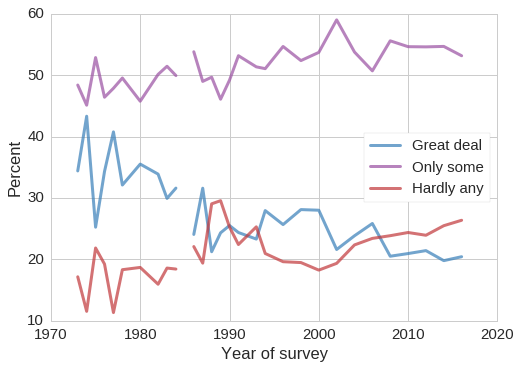

In [149]:
plot_conf(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent', loc='center right')

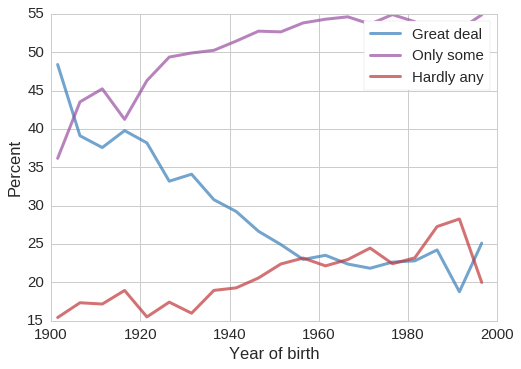

In [150]:
plot_conf(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [151]:
make_model(sample, 'confident').summary()

Optimization terminated successfully.
         Current function value: 0.580900
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              confident   No. Observations:                40724
Model:                          Logit   Df Residuals:                    40718
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                 0.01892
Time:                        16:56:34   Log-Likelihood:                -23657.
converged:                       True   LL-Null:                       -24113.
                                        LLR p-value:                6.071e-195
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4555      0.029    -49.584      0.000      -1.513      -1.398
c             -0.0129      0.003     -4.301      0.000      -0.019      -0.007
c2             0.0002   7.35e-05      2.380      0.017    3.09e-05       0.000
a             -0.0062      0.003     -1.972      0.049      -0.012   -3.67e-05
a2             0.0005   8.93e-05      5.842      0.000       0.000       0.001
ac             0.0002      0.000      1.586      0.113   -5.64e-05       0.001
==============================================================================
"""

In [152]:
make_model(sample, 'someconf').summary()

Optimization terminated successfully.
         Current function value: 0.689656
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               someconf   No. Observations:                40724
Model:                          Logit   Df Residuals:                    40718
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                0.004545
Time:                        16:56:35   Log-Likelihood:                -28086.
converged:                       True   LL-Null:                       -28214.
                                        LLR p-value:                 2.283e-53
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2601      0.024     10.696      0.000       0.212       0.308
c              0.0032      0.003      1.257      0.209      -0.002       0.008
c2            -0.0001   6.46e-05     -1.739      0.082      -0.000    1.43e-05
a              0.0024      0.003      0.870      0.384      -0.003       0.008
a2            -0.0002   8.02e-05     -2.819      0.005      -0.000   -6.88e-05
ac         -4.031e-05      0.000     -0.302      0.762      -0.000       0.000
==============================================================================
"""

In [153]:
make_model(sample, 'noconf').summary()

Optimization terminated successfully.
         Current function value: 0.508129
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 noconf   No. Observations:                40724
Model:                          Logit   Df Residuals:                    40718
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                0.005707
Time:                        16:56:35   Log-Likelihood:                -20693.
converged:                       True   LL-Null:                       -20812.
                                        LLR p-value:                 2.578e-49
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0834      0.029    -37.951      0.000      -1.139      -1.027
c              0.0060      0.003      1.946      0.052   -4.44e-05       0.012
c2            -0.0002   7.94e-05     -2.145      0.032      -0.000   -1.47e-05
a              0.0008      0.003      0.244      0.807      -0.006       0.007
a2            -0.0004   9.99e-05     -3.574      0.000      -0.001      -0.000
ac            -0.0004      0.000     -2.176      0.030      -0.001   -3.57e-05
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 1.015407
         Iterations 5


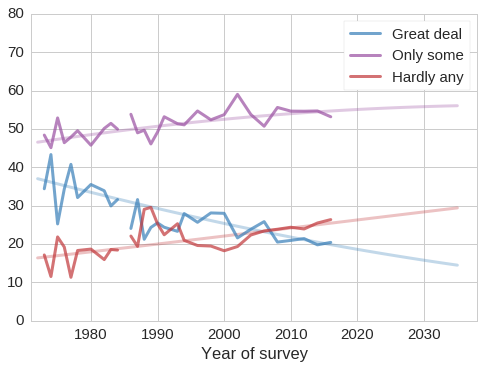

In [154]:
var = 'conclerg'
varnames = ['confident', 'someconf', 'noconf']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1972, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_conf(grouped_year)

thinkplot.config(xlim=[1971, 2038], ylim=[0, 80])

In [155]:
make_multi_pred(sample, var, varnames, train_year, [1976, 2016, 2036], factors, index)

Optimization terminated successfully.
         Current function value: 1.015407
         Iterations 5


,confident,someconf,noconf
1976,35.250709,47.567067,17.182225
2016,19.860245,54.688661,25.451095
2036,14.253418,56.106384,29.640198


## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [156]:
def plot_bible(grouped):
    """Plot bible interpretation categories.
    
    grouped: GroupBy object
    """
    varnames = ['word', 'inspired', 'legends']
    colors = [BLUE, PURPLE, RED]
    labels = ['Literal', 'Inspired', 'Legends']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

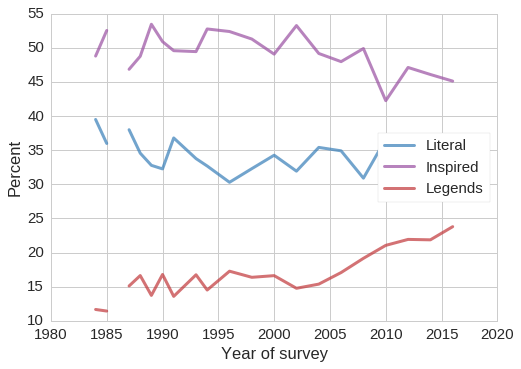

In [157]:
plot_bible(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent', loc='center right')

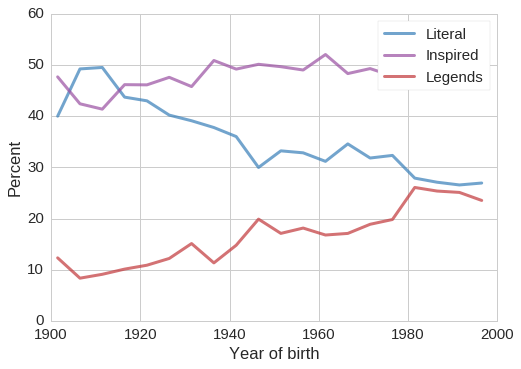

In [158]:
plot_bible(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [159]:
make_model(sample, 'word').summary()

Optimization terminated successfully.
         Current function value: 0.634281
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   word   No. Observations:                32805
Model:                          Logit   Df Residuals:                    32799
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                0.004791
Time:                        16:56:38   Log-Likelihood:                -20808.
converged:                       True   LL-Null:                       -20908.
                                        LLR p-value:                 2.384e-41
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7564      0.023    -33.208      0.000      -0.801      -0.712
c             -0.0026      0.004     -0.702      0.482      -0.010       0.005
c2             0.0002      0.000      1.084      0.278      -0.000       0.000
a              0.0045      0.004      1.202      0.229      -0.003       0.012
a2          5.453e-05      0.000      0.347      0.728      -0.000       0.000
ac             0.0002      0.000      0.532      0.595      -0.000       0.001
==============================================================================
"""

In [160]:
make_model(sample, 'inspired').summary()

Optimization terminated successfully.
         Current function value: 0.691540
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               inspired   No. Observations:                32805
Model:                          Logit   Df Residuals:                    32799
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                0.001953
Time:                        16:56:39   Log-Likelihood:                -22686.
converged:                       True   LL-Null:                       -22730.
                                        LLR p-value:                 1.206e-17
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1540      0.021     -7.185      0.000      -0.196      -0.112
c             -0.0208      0.003     -6.079      0.000      -0.027      -0.014
c2            -0.0006      0.000     -4.318      0.000      -0.001      -0.000
a             -0.0206      0.004     -5.839      0.000      -0.027      -0.014
a2            -0.0004      0.000     -2.533      0.011      -0.001   -8.51e-05
ac            -0.0009      0.000     -3.405      0.001      -0.001      -0.000
==============================================================================
"""

In [161]:
make_model(sample, 'legends').summary()

Optimization terminated successfully.
         Current function value: 0.461296
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                legends   No. Observations:                32805
Model:                          Logit   Df Residuals:                    32799
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 May 2017   Pseudo R-squ.:                 0.01098
Time:                        16:56:39   Log-Likelihood:                -15133.
converged:                       True   LL-Null:                       -15301.
                                        LLR p-value:                 1.851e-70
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2663      0.027    -47.615      0.000      -1.318      -1.214
c              0.0363      0.004      8.315      0.000       0.028       0.045
c2             0.0006      0.000      3.445      0.001       0.000       0.001
a              0.0266      0.005      5.889      0.000       0.018       0.035
a2             0.0005      0.000      2.662      0.008       0.000       0.001
ac             0.0012      0.000      3.420      0.001       0.001       0.002
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 1.016086
         Iterations 5


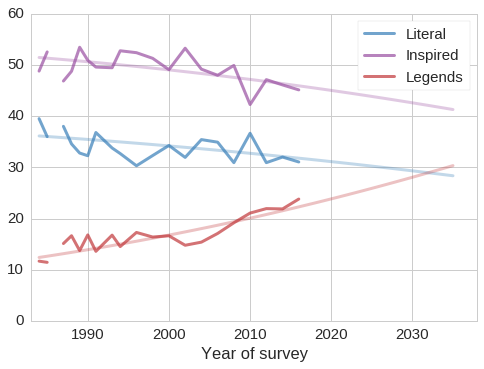

In [162]:
var = 'bible'
varnames = ['word', 'inspired', 'legends']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1984, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_bible(grouped_year)

thinkplot.config(xlim=[1983, 2038], ylim=[0, 60])

In [163]:
make_multi_pred(sample, var, varnames, train_year, [1986, 2016, 2036], factors, index)

Optimization terminated successfully.
         Current function value: 1.016086
         Iterations 5


,word,inspired,legends
1986,35.918045,51.209545,12.872410
2016,31.791786,45.936838,22.271376
2036,28.159222,41.031419,30.809359
